# Import RPB model along with other utility functions

In [1]:
from RPB_model import *

# Creating model for a single side/section of the RPB

In [3]:
# Create model instance. Currently, mode can be either "adsorption" or "desorption" which sets the initial values and boundary conditions for each case.
# m=RPB_model(mode="adsorption", gas_flow_direction=1)
# or
RPB = RotaryPackedBed()
RPB.ads = Block()
add_single_section_equations(RPB.ads, mode="adsorption", gas_flow_direction=1)

# Custom initialization routine. Uses block initialization function.
single_section_init(RPB.ads)

DOF = 0
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See

In [4]:
# Some various utility functions to check model performance
evaluate_MB_error(RPB.ads)

print(f'CO2 Capture = {RPB.ads.CO2_capture():.3}')

AttributeError: 'ScalarBlock' object has no attribute 'component_list'

In [ ]:
# scaling functions

# check_scaling(m)

# jac, variables, constraints = scaling_script(m)

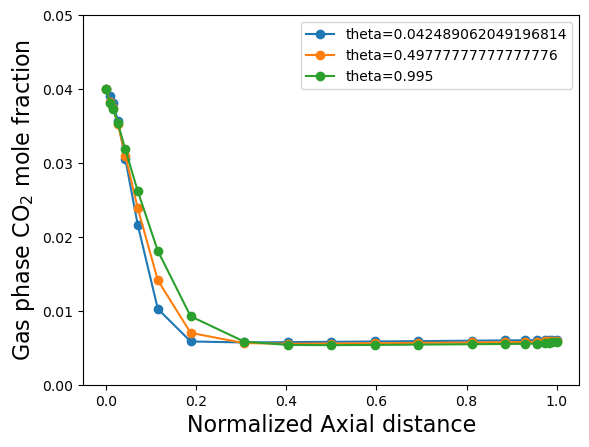

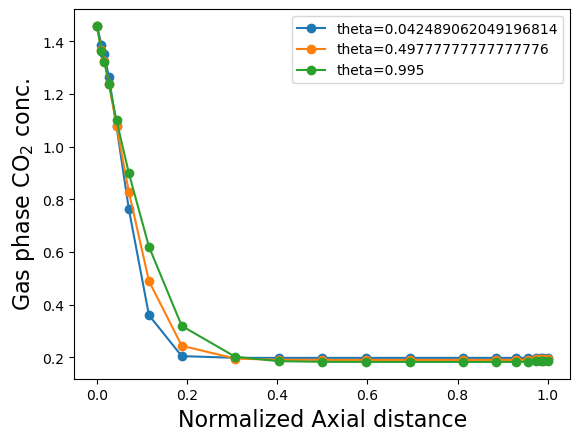

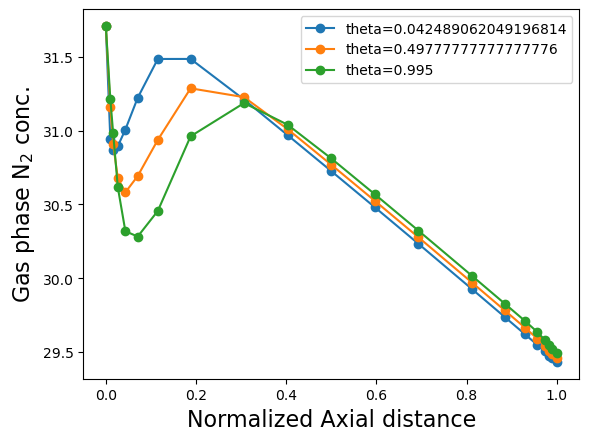

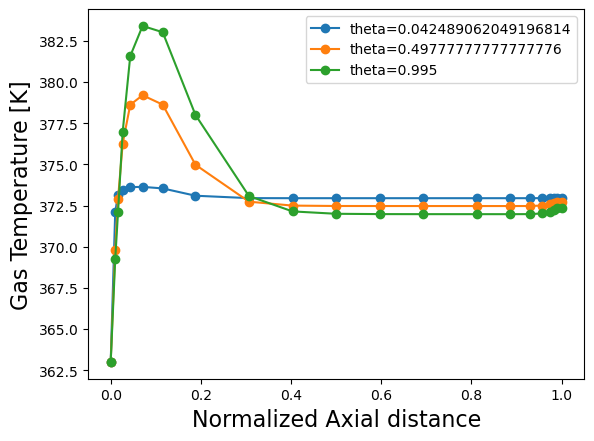

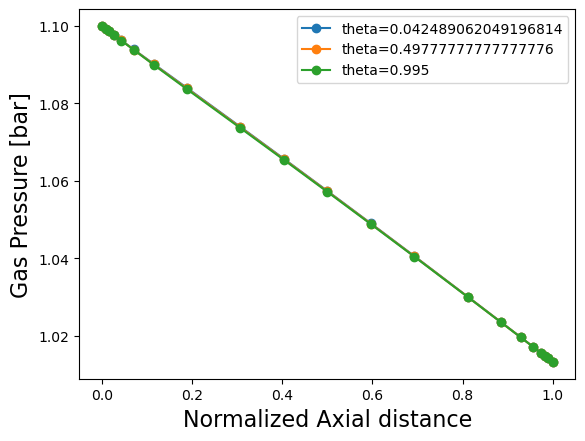

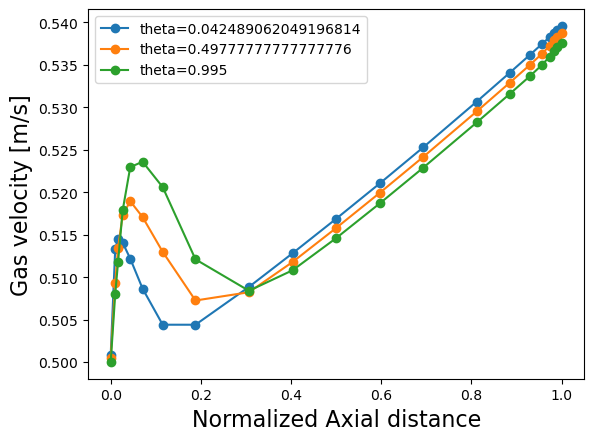

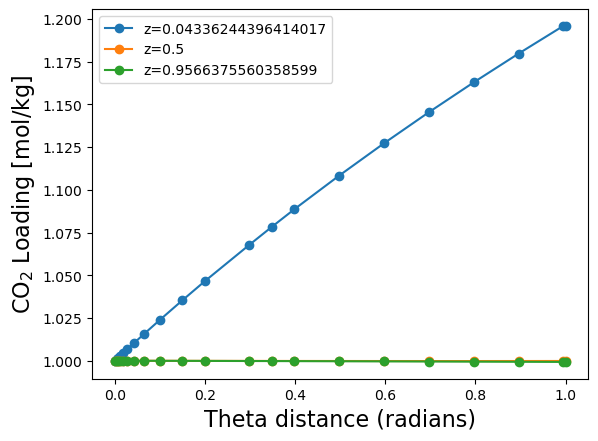

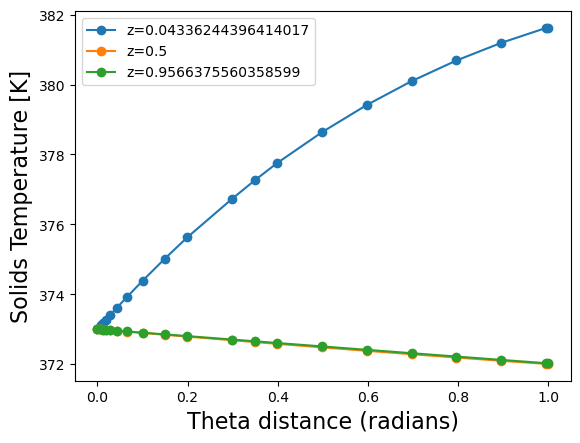

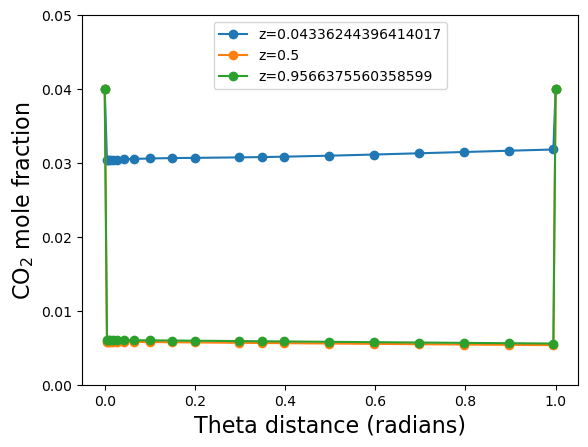

In [5]:
plotting(RPB.ads)

# Creating a full RPB model

From scratch

In [ ]:
# create pyomo model
RPB = full_model_creation(lean_temp_connection=True, configuration = "counter-current")

In [ ]:
RPB.ads.P.setub(1.26)
RPB.ads.P_in.setub(1.26)

RPB.des.P.setub(1.04)

RPB.ads.L.fix(7.811853)
RPB.ads.theta.fix(0.606758)
RPB.des.P_in.fix(1.034350)
RPB.ads.Tx.fix(347.700154)
RPB.des.Tx.fix(433)
# RPB.ads.w_rpm.fix(0.003502)
RPB.ads.P_in.fix(1.250714)

In [ ]:
# initialize using BlockTriangularizationInitializer() with a list of values for initialization factors within the models
init_routine_1(RPB, homotopy_points=[1e-5,1e-4,1e-3,1e-2] + np.linspace(0.1,1,5).tolist())

In [ ]:
init_obj = BlockTriangularizationInitializer()

init_obj.config.block_solver_call_options = {"tee": True}
init_obj.config.block_solver_options = {
    # "halt_on_ampl_error": "yes",
    "max_iter": 1000,
}

# target = 0.003502
targets = [0.1,0.05,0.01,0.005,0.003502]

for target in targets:

    steps = np.linspace(0,1,10)

    points = [(target - RPB.ads.w_rpm())*i + RPB.ads.w_rpm() for i in steps]

    for i in points:
        RPB.ads.w_rpm.fix(i)
        
        init_obj.initialization_routine(RPB)

    solver = SolverFactory("ipopt")
    solver.options = {
        "max_iter": 500,
        "bound_push": 1e-22,
        "halt_on_ampl_error": "yes",
    }
    solver.solve(RPB, tee=True).write()

In [ ]:
get_init_factors(RPB.ads) # these should all be = 1

In [ ]:
report(RPB)

From a previous solution

In [ ]:
# create pyomo model
RPB = full_model_creation(lean_temp_connection=True, configuration = "counter-current")

# load a previous solution and solve
from_json(RPB, fname="base case solution 012424.json.gz", gz=True)

solver = SolverFactory("ipopt")
solver.options = {
    "max_iter": 1000,
    "bound_push": 1e-22,
    "halt_on_ampl_error": "yes",
}
solver.solve(RPB, tee=True).write()

In [ ]:
report(RPB)

In [ ]:
evaluate_MB_error(RPB.ads)
print(' ')
evaluate_MB_error(RPB.des)

In [ ]:
# different scaling functions

# check_scaling(RPB)

# jac, variables, constraints = scaling_script(RPB)

# Optimization

start from initialized model

In [ ]:
# starting from initialized model. Change design to fix capture by freeing up inlet adsorber pressure

RPB.ads.P_in.unfix()
RPB.ads.CO2_capture.fix(0.95)

solver = SolverFactory("ipopt")
solver.options = {
    "max_iter": 1000,
    "bound_push": 1e-22,
    # "halt_on_ampl_error": "yes",
}
solver.solve(RPB, tee=True).write()

In [ ]:
# create regularization parameter for the objective function
RPB.alpha_obj = Param(initialize=0.5, mutable=True)

# add objective
@RPB.Expression()
def obj(RPB):
    return RPB.alpha_obj * RPB.energy_requirement - (1 - RPB.alpha_obj) * RPB.productivity

RPB.objective = Objective(expr=RPB.obj)

RPB.objective.pprint()

In [ ]:
# set bounds for decision variables
RPB.ads.L.setlb(0.01)
RPB.ads.L.setub(40)
RPB.des.L.setlb(0.01)
RPB.des.L.setub(40)
RPB.ads.L.pprint()

In [ ]:
RPB.ads.Tx.setlb(25+273)
RPB.ads.Tx.setub(95+273)
RPB.ads.Tx.pprint()

In [ ]:
RPB.des.Tx.setlb(100+273)
RPB.des.Tx.setub(160+273)
RPB.des.Tx.pprint()

In [ ]:
RPB.ads.P_in.setub(1.5)
RPB.ads.P_in.pprint()
RPB.ads.P.setub(1.5)

In [ ]:
RPB.des.P_in.setub(1.5)
RPB.des.P_in.setlb(1.01325)
RPB.des.P.setub(1.5)
RPB.des.P_in.pprint()

In [ ]:
RPB.ads.w_rpm.setlb(0.00001)
RPB.ads.w_rpm.setub(0.005)
RPB.ads.w_rpm.pprint()

In [ ]:
# free up decision variables (keep des.Tx fixed for first run the free up later)
RPB.ads.L.unfix()
RPB.ads.theta.unfix()
RPB.des.P_in.unfix()
RPB.ads.Tx.unfix()
RPB.des.Tx.unfix()
RPB.ads.w_rpm.unfix()

In [ ]:
degrees_of_freedom(RPB)

In [ ]:
RPB.ads.w_rpm.unfix()

In [ ]:
# solve using conopt thorugh gams
results = SolverFactory("gams").solve(
    RPB,
    tee=True,
    keepfiles=True,
    solver="conopt4",
    tmpdir="temp",
    add_options=["gams_model.optfile=1;"],
)

In [ ]:
# or solve using ipopt
# solver = SolverFactory("ipopt")
# solver.options = {
#     "max_iter": 1000,
#     "bound_push": 1e-8,
#     # "halt_on_ampl_error": "yes",
#     "tol": 1e-4,
#     "max_cpu_time": 5*60,
#     # "mu_strategy": "adaptive",
# }
# solver.solve(RPB, tee=True).write()

In [ ]:
results_df = report(RPB)
results_df

In [ ]:
evaluate_MB_error(RPB.ads)
print(' ')
evaluate_MB_error(RPB.des)

In [ ]:
# custom function using degeneracy hunter. Mainly to see if any variables are pushing their bounds
degen_hunter(RPB)

start from previous optimized case

In [ ]:
# create pyomo model
RPB = full_model_creation(lean_temp_connection=True, configuration = "counter-current")

In [ ]:
# create regularization parameter for the objective function
RPB.alpha_obj = Param(initialize=0.5, mutable=True)

# add objective
@RPB.Expression()
def obj(RPB):
    return RPB.alpha_obj * RPB.energy_requirement - (1 - RPB.alpha_obj) * RPB.productivity

RPB.objective = Objective(expr=RPB.obj)

RPB.objective.pprint()

In [ ]:
# set bounds for decision variables
RPB.ads.L.setlb(0.01)
RPB.ads.L.setub(40)
RPB.des.L.setlb(0.01)
RPB.des.L.setub(40)
RPB.ads.L.pprint()

In [ ]:
RPB.ads.Tx.setlb(25+273)
RPB.ads.Tx.setub(95+273)
RPB.ads.Tx.pprint()

In [ ]:
RPB.des.Tx.setlb(100+273)
RPB.des.Tx.setub(160+273)
RPB.des.Tx.pprint()

In [ ]:
RPB.ads.P_in.setub(1.5)
RPB.ads.P_in.pprint()
RPB.ads.P.setub(1.5)

In [ ]:
RPB.des.P_in.setub(1.5)
RPB.des.P_in.setlb(1.01325)
RPB.des.P.setub(1.5)
RPB.des.P_in.pprint()

In [ ]:
RPB.ads.w_rpm.setlb(0.00001)
RPB.ads.w_rpm.setub(0.1)
RPB.ads.w_rpm.pprint()

In [ ]:
# load a previous solution and solve
from_json(RPB, fname="opt solution 012424.json.gz", gz=True)

In [ ]:
RPB.alpha_obj.pprint()

In [ ]:
# free up decision variables (keep des.Tx fixed for first run the free up later)
RPB.ads.L.unfix()
RPB.ads.theta.unfix()
RPB.des.P_in.unfix()
RPB.ads.Tx.unfix()
RPB.des.Tx.unfix()
RPB.ads.w_rpm.unfix()

In [ ]:
degrees_of_freedom(RPB)

In [ ]:
# solve using conopt thorugh gams
results = SolverFactory("gams").solve(
    RPB,
    tee=True,
    keepfiles=True,
    solver="conopt4",
    tmpdir="temp",
    add_options=["gams_model.optfile=1;"],
)

In [ ]:
report(RPB)

In [ ]:
degen_hunter(RPB)

pareto front generation

In [ ]:
# list of alpha values to use in the objective function
alpha_list=[
    0.0001,
    0.001,
    0.005,
    0.01,
    0.02,
    0.05,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    0.925,
    0.95,
    0.975,
    0.99,
    0.999,
]

In [ ]:
# optimize for every value and store the results
E = []
P = []

for j in alpha_list:
    RPB.alpha_obj = j

    results = SolverFactory("gams").solve(
        RPB,
        tee=True,
        keepfiles=True,
        solver="conopt4",
        tmpdir="temp",
        add_options=["gams_model.optfile=1;"],
    )

    print(f'alpha = {j}, E={RPB.energy_requirement()}, P={RPB.productivity()}')

    E.append(RPB.energy_requirement())
    P.append(RPB.productivity())


In [ ]:
pd.DataFrame({'alpha':alpha_list,'E':E,'P':P})

In [ ]:
plt.scatter(E,P)

# Polishing step simulation and optimization

start from previous optimized case

In [ ]:
# create pyomo model
RPB = full_model_creation(lean_temp_connection=True, configuration = "counter-current")

In [ ]:
# create regularization parameter for the objective function
RPB.alpha_obj = Param(initialize=0.5, mutable=True)

# add objective
@RPB.Expression()
def obj(RPB):
    return RPB.alpha_obj * RPB.energy_requirement - (1 - RPB.alpha_obj) * RPB.productivity

RPB.objective = Objective(expr=RPB.obj)

RPB.objective.pprint()

In [ ]:
# set bounds for decision variables
RPB.ads.L.setlb(0.01)
RPB.ads.L.setub(40)
RPB.des.L.setlb(0.01)
RPB.des.L.setub(40)
RPB.ads.L.pprint()

In [ ]:
RPB.ads.Tx.setlb(25+273)
RPB.ads.Tx.setub(95+273)
RPB.ads.Tx.pprint()

In [ ]:
RPB.des.Tx.setlb(100+273)
RPB.des.Tx.setub(160+273)
RPB.des.Tx.pprint()

In [ ]:
RPB.ads.P_in.setub(1.5)
RPB.ads.P_in.pprint()
RPB.ads.P.setub(1.5)

In [ ]:
RPB.des.P_in.setub(1.5)
RPB.des.P_in.setlb(1.01325)
RPB.des.P.setub(1.5)
RPB.des.P_in.pprint()

In [ ]:
RPB.ads.w_rpm.setlb(0.00001)
RPB.ads.w_rpm.setub(0.1)
RPB.ads.w_rpm.pprint()

In [ ]:
# load a previous solution and solve (will also load the inlet gas feed conc.)
from_json(RPB, fname="polishing step optimized solution 031824.json.gz", gz=True)

In [ ]:
# solve using conopt thorugh gams
results = SolverFactory("gams").solve(
    RPB,
    tee=True,
    keepfiles=True,
    solver="conopt4",
    tmpdir="temp",
    add_options=["gams_model.optfile=1;"],
)

In [ ]:
report(RPB)

# Plotting

In [ ]:
full_contactor_plotting(RPB)

# Save Model

In [ ]:
# save model
to_json(RPB, fname="base case solution 012424.json.gz", gz=True, human_read=False)

# Diagnostics testing

In [ ]:
iscale.set_scaling_factor(RPB.ads.Tg_out_eq, 0.1)
iscale.set_scaling_factor(RPB.des.Tg_out_eq, 0.1)

for z in RPB.ads.z:
    for o in RPB.ads.o:
        if 0 < z < 1 and 0 < o < 1:
            iscale.set_scaling_factor(RPB.des.pde_solidEB[z,o], 1e-2)
            iscale.set_scaling_factor(RPB.ads.Q_gs_eq[z, o], 0.001)

In [ ]:
# solve using conopt thorugh gams
results = SolverFactory("gams").solve(
    RPB,
    tee=True,
    keepfiles=True,
    solver="conopt4",
    tmpdir="temp",
    add_options=["gams_model.optfile=1;"],
)

In [ ]:
RPB.ads.L.fix()
RPB.ads.theta.fix()
RPB.des.P_in.fix()
RPB.ads.Tx.fix()
RPB.des.Tx.fix()
RPB.ads.w_rpm.fix()

degrees_of_freedom(RPB) # need dof=0 for diagnostic tools

In [ ]:
from idaes.core.util.model_diagnostics import DiagnosticsToolbox

In [ ]:
diagtool = DiagnosticsToolbox(RPB)

In [ ]:
diagtool.report_structural_issues()

In [ ]:
diagtool.report_numerical_issues()

In [ ]:
diagtool.display_constraints_with_extreme_jacobians()

In [ ]:
iscale.get_scaling_factor(RPB.ads.Q_gs_eq[0.5,0.005])

In [ ]:
value(RPB.des.Cp_g_out * RPB.des.Tg_out)

In [ ]:
m=RPB.des
z=0.8846928460920032
o=0.005

value((1 - m.eb) * m.rho_sol * m.Cp_sol * m.w * m.dTsdo[z, o])

In [ ]:
print(units.get_units(RPB.productivity))

In [ ]:
from pyomo.util.check_units import assert_units_consistent, assert_units_equivalent, check_units_equivalent

In [ ]:
assert_units_consistent(RPB.lean_temp_constraint)

In [ ]:
check_scaling(RPB)

In [ ]:
m=RPB.des
z=0.8846928460920032
o=0.005

m.Q_gs[z, o]()

In [ ]:
RPB.ads.Q_gs_eq[0.04336244396414017,0.005]()/RPB.ads.R_HT_gs() * RPB.ads.h_gs[0.04336244396414017,0.005]() * RPB.ads.a_s()